In [2]:
from google.colab import files
x = files.upload()

Saving DataSetSplitted.zip to DataSetSplitted.zip


In [3]:
! unzip DataSetSplitted.zip

Archive:  DataSetSplitted.zip
   creating: DataSet/
   creating: DataSet/test/
   creating: DataSet/test/human/
  inflating: DataSet/test/human/Angelina-Jolie-100x130cm-2013.jpg  
  inflating: DataSet/test/human/b53d30e509b44bfc5f7bf3d3a03cc000fcd50623.jpeg  
  inflating: DataSet/test/human/dam-images-daily-2014-11-martin-schoeller-portraits-martin-schoeller-portraits-02.jpg  
  inflating: DataSet/test/human/default.jpg  
  inflating: DataSet/test/human/image24.jpeg  
  inflating: DataSet/test/human/image32.jpeg  
  inflating: DataSet/test/human/image33.jpeg  
  inflating: DataSet/test/human/images102.jpg  
  inflating: DataSet/test/human/images113.jpg  
  inflating: DataSet/test/human/images114.jpg  
  inflating: DataSet/test/human/images147.jpg  
  inflating: DataSet/test/human/images148.jpg  
  inflating: DataSet/test/human/images149.jpg  
  inflating: DataSet/test/human/images184.jpg  
  inflating: DataSet/test/human/images185.jpg  
  inflating: DataSet/test/human/images193.jpg  
 

In [4]:
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121, VGG16
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [5]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
my_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = my_generator.flow_from_directory( './DataSet/train/', target_size=(150, 150), batch_size=4, class_mode='binary')
valid_generator = my_generator.flow_from_directory( './DataSet/validate/', target_size=(150, 150), batch_size=4, class_mode='binary')
test_generator = my_generator.flow_from_directory('./DataSet/test/', target_size=(150, 150), batch_size=4, class_mode='binary')

Found 738 images belonging to 2 classes.
Found 156 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


In [8]:
EPOCHS = 100
checkpoint_filepath = 'best.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss', verbose=1,mode='min',save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

In [9]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [10]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [11]:
def ResNet50(input_shape=(150, 150, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [12]:
base_model = ResNet50(input_shape=(150, 150, 3))

In [13]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [14]:
model = Model(inputs=base_model.input, outputs=headModel)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1[0][0]']              

In [16]:
base_model.load_weights("/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7febdb780ad0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7febeafca0d0> False
<keras.layers.convolutional.Conv2D object at 0x7febddf17910> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7febddf17210> False
<keras.layers.core.activation.Activation object at 0x7febddee7290> False
<keras.layers.pooling.MaxPooling2D object at 0x7febddeaf3d0> False
<keras.layers.convolutional.Conv2D object at 0x7febdde4ad90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7febdde505d0> False
<keras.layers.core.activation.Activation object at 0x7febdde43f10> False
<keras.layers.convolutional.Conv2D object at 0x7febdde5ee90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7febdde63850> False
<keras.layers.core.activation.Activation object at 0x7febdde5efd0> False
<keras.layers.convolutional.Conv2D object at 0x7febdde718d0> False
<keras

In [19]:
model.compile( optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history = model.fit(train_generator,validation_data=valid_generator,epochs=100,verbose=1,callbacks=[checkpoint,earlystopping])

Epoch 1/100
143/185 [======================>.......] - ETA: 15s - loss: 1.0374 - accuracy: 0.6351

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


185/185 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.6409
Epoch 1: val_loss improved from inf to 0.60936, saving model to best.h5
185/185 [==============================] - 84s 434ms/step - loss: 0.9584 - accuracy: 0.6409 - val_loss: 0.6094 - val_accuracy: 0.6474
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.7046
Epoch 2: val_loss improved from 0.60936 to 0.58865, saving model to best.h5
185/185 [==============================] - 80s 434ms/step - loss: 0.5972 - accuracy: 0.7046 - val_loss: 0.5886 - val_accuracy: 0.6795
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7371
Epoch 3: val_loss did not improve from 0.58865
185/185 [==============================] - 79s 425ms/step - loss: 0.5451 - accuracy: 0.7371 - val_loss: 0.6332 - val_accuracy: 0.7051
Epoch 4/100
185/185 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7575
Epoch 4: val_loss did not i

In [20]:
model.load_weights('best.h5')
model.evaluate(test_generator)

25/36 [===================>..........] - ETA: 3s - loss: 0.4198 - accuracy: 0.8000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/36 [==============================] - 13s 361ms/step - loss: 0.3937 - accuracy: 0.8333


[0.3937181234359741, 0.8333333134651184]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0, 0.5, 'Accuracy')

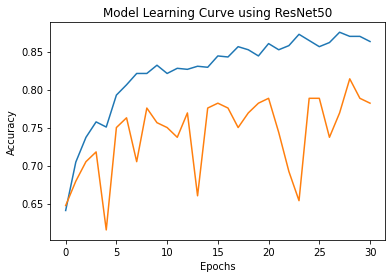

In [21]:
print(history.history.keys())
keyList = list(history.history.keys())
plt.plot(history.history[keyList[1]],label = "Training accuracy" )
plt.plot(history.history[keyList[3]], label = "Validation accuracy" )
plt.title("Model Learning Curve using ResNet50")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [22]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    return model

In [23]:
model2=VGG16()

In [24]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                    

In [25]:
Vgg16 = Model(inputs=model2.input, outputs=model2.get_layer('vgg16').output)

In [26]:
Vgg16.load_weights("/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [27]:
for layer in Vgg16.layers:
    layer.trainable = False

In [28]:
for layer in model2.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7febd57d8e50> False
<keras.layers.convolutional.Conv2D object at 0x7febddadfe90> False
<keras.layers.pooling.MaxPooling2D object at 0x7febd57f8090> False
<keras.layers.convolutional.Conv2D object at 0x7febdde40050> False
<keras.layers.convolutional.Conv2D object at 0x7febd36a5ed0> False
<keras.layers.pooling.MaxPooling2D object at 0x7febd57de190> False
<keras.layers.convolutional.Conv2D object at 0x7febd57deb10> False
<keras.layers.convolutional.Conv2D object at 0x7febd5883e50> False
<keras.layers.convolutional.Conv2D object at 0x7febddfe7fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7febd57cf110> False
<keras.layers.convolutional.Conv2D object at 0x7febd5331b10> False
<keras.layers.convolutional.Conv2D object at 0x7febd533af50> False
<keras.layers.convolutional.Conv2D object at 0x7febd5343910> False
<keras.layers.pooling.MaxPooling2D object at 0x7febd532cc10> False
<keras.layers.convolutional.Conv2D object at 0x7febd53475d0> F

In [29]:
model2.compile( optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )

In [30]:
history2 = model2.fit(train_generator,validation_data=valid_generator,epochs=100,verbose=1,callbacks=[checkpoint,earlystopping])

Epoch 1/100
136/185 [=====================>........] - ETA: 41s - loss: 0.3952 - accuracy: 0.8621

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


185/185 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8753
Epoch 1: val_loss did not improve from 0.44020
185/185 [==============================] - 188s 1s/step - loss: 0.3580 - accuracy: 0.8753 - val_loss: 0.5839 - val_accuracy: 0.8462
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9593
Epoch 2: val_loss did not improve from 0.44020
185/185 [==============================] - 188s 1s/step - loss: 0.1512 - accuracy: 0.9593 - val_loss: 0.8017 - val_accuracy: 0.8013
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9797
Epoch 3: val_loss improved from 0.44020 to 0.34402, saving model to best.h5
185/185 [==============================] - 188s 1s/step - loss: 0.1068 - accuracy: 0.9797 - val_loss: 0.3440 - val_accuracy: 0.9038
Epoch 4/100
185/185 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9824
Epoch 4: val_loss did not improve from 0.34402
185/185 [==

In [31]:
model2.load_weights('best.h5')
model2.evaluate(test_generator)

33/36 [==========================>...] - ETA: 2s - loss: 0.2868 - accuracy: 0.9394

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/36 [==============================] - 31s 855ms/step - loss: 0.3035 - accuracy: 0.9306


[0.3034600019454956, 0.9305555820465088]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0, 0.5, 'Accuracy')

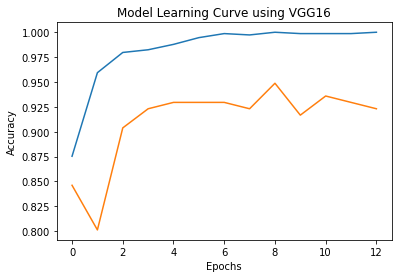

In [34]:
print(history2.history.keys())
keyList = list(history2.history.keys())
plt.plot(history2.history[keyList[1]],label = "Training accuracy" )
plt.plot(history2.history[keyList[3]], label = "Validation accuracy" )
plt.title("Model Learning Curve using VGG16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 150, 150, 3
n_classes = 1
model1 = densenet(input_shape,n_classes)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 75, 75, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 38, 38, 64)  0           ['conv2d_13[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 38, 38, 64)  256         ['max_pooling2d_5[0][0]']  

In [36]:
model1.compile( optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )

In [37]:
history1 = model1.fit(train_generator,validation_data=valid_generator,epochs=100,verbose=1,callbacks=[checkpoint,earlystopping])

Epoch 1/100
151/185 [=======================>......] - ETA: 47s - loss: 1.3018 - accuracy: 0.4900

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


185/185 [==============================] - ETA: 0s - loss: 1.1703 - accuracy: 0.4986
Epoch 1: val_loss did not improve from 0.34402
185/185 [==============================] - 308s 2s/step - loss: 1.1703 - accuracy: 0.4986 - val_loss: 1.0087 - val_accuracy: 0.4936
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.4986
Epoch 2: val_loss did not improve from 0.34402
185/185 [==============================] - 275s 1s/step - loss: 0.6135 - accuracy: 0.4986 - val_loss: 0.7244 - val_accuracy: 0.4936
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.4986
Epoch 3: val_loss did not improve from 0.34402
185/185 [==============================] - 276s 1s/step - loss: 0.5629 - accuracy: 0.4986 - val_loss: 0.8874 - val_accuracy: 0.4936
Epoch 4/100
185/185 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.4986
Epoch 4: val_loss did not improve from 0.34402
185/185 [==============================]

In [38]:
model1.load_weights('best.h5')
model1.evaluate(test_generator)

12/36 [=========>....................] - ETA: 7s - loss: 0.4872 - accuracy: 0.5000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/36 [==============================] - 12s 343ms/step - loss: 0.3623 - accuracy: 0.4931


[0.3623307943344116, 0.4930555522441864]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0, 0.5, 'Accuracy')

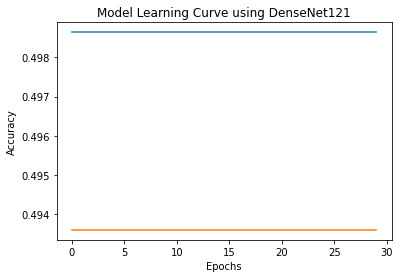

In [39]:
print(history1.history.keys())
keyList = list(history1.history.keys())
plt.plot(history1.history[keyList[1]],label = "Training accuracy" )
plt.plot(history1.history[keyList[3]], label = "Validation accuracy" )
plt.title("Model Learning Curve using DenseNet121")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")